<a href="https://colab.research.google.com/github/muhammadmo/COVID19_classification_transferlearning/blob/main/CT_Scan/COVID19_Classification(CT_Scan%26ResNet152).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadmoosavi","key":"1fa1bc8aae4bfd517b860f44615ff8d9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d maedemaftouni/large-covid19-ct-slice-dataset

 99% 2.05G/2.06G [00:17<00:00, 136MB/s]
100% 2.06G/2.06G [00:17<00:00, 128MB/s]


In [ ]:
!kaggle datasets download -d drsurabhithorat/covid-19-ct-scan-dataset

 99% 1.03G/1.04G [00:08<00:00, 140MB/s]
100% 1.04G/1.04G [00:08<00:00, 136MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "large-covid19-ct-slice-dataset.zip"

with ZipFile(file_name,'r') as zipp:
  zipp.extractall()
print('done') 

done


In [ ]:
from zipfile import ZipFile
file_name = "covid-19-ct-scan-dataset.zip"

with ZipFile(file_name,'r') as zipp:
  zipp.extractall()
print('done') 

done


In [ ]:
pip install split_folders

In [ ]:
import splitfolders
input_folder = "/content/dataset"
output = "/content/splited_dataset"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .1, .2)) 

Copying files: 10239 files [00:05, 1905.46 files/s]


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np             
import pandas as pd           

train_path = '/content/splited_dataset/train'
test_path = '/content/splited_dataset/test'
valid_path = '/content/splited_dataset/val'

#set defult image size
batch_size = 16
img_width = 224
img_height = 224

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rotation_range=15,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                rescale = 1./255,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='sparse',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse', 
      batch_size=batch_size
      )


Found 7165 images belonging to 3 classes.
Found 2051 images belonging to 3 classes.
Found 1022 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import ResNet152

conv_base = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

234708992/234698864 [==============================] - 2s 0us/step


In [ ]:
conv_base.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
from keras import models
from keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

optimizer = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

model = models.Sequential()

model.add(Conv2D(3, (3, 3), padding="same", activation="relu", input_shape=(img_width, img_height, 1)))

model.add(conv_base)

model.add(GlobalAveragePooling2D())

model.add(layers.Flatten())
#model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
#model.add(layers.BatchNormalization())

#model.add(layers.Dense(4096, activation='relu'))
#model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(3,activation="softmax"))
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer = RMSprop(lr=1e-2) , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

conv_base.trainable = False
#fine-tuning
'''
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
'''
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                        

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

#early stopping
early = EarlyStopping(monitor="val_loss", 
                      mode="auto", 
                      patience=9)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 4, verbose=1,factor=1e-1, min_lr=0.000001)

checkpoint_filepath = 'checkpointCNN.h5'
Model_check = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

callbacks_list = [ early, learning_rate_reduction]

In [ ]:
history = model.fit(train,
                    batch_size=16,
                    epochs=30,
                    validation_data=valid,
                    callbacks=[early,learning_rate_reduction, Model_check])

Epoch 1/30
448/448 [==============================] - ETA: 0s - loss: 0.2936 - accuracy: 0.8748
Epoch 1: val_loss improved from inf to 3.86759, saving model to checkpointCNN.h5
448/448 [==============================] - 650s 1s/step - loss: 0.2936 - accuracy: 0.8748 - val_loss: 3.8676 - val_accuracy: 0.5088 - lr: 0.0030
Epoch 2/30
448/448 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.9531
Epoch 2: val_loss improved from 3.86759 to 1.41119, saving model to checkpointCNN.h5
448/448 [==============================] - 610s 1s/step - loss: 0.1245 - accuracy: 0.9531 - val_loss: 1.4112 - val_accuracy: 0.5078 - lr: 0.0030
Epoch 3/30
448/448 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9626
Epoch 3: val_loss improved from 1.41119 to 0.25377, saving model to checkpointCNN.h5
448/448 [==============================] - 611s 1s/step - loss: 0.0944 - accuracy: 0.9626 - val_loss: 0.2538 - val_accuracy: 0.8865 - lr: 0.0030
Epoch 4/30
448/448 [======

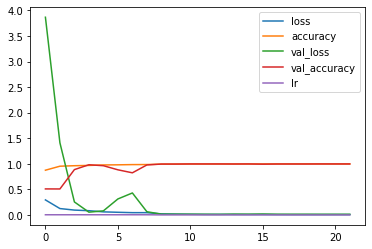

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')
preds = model.predict(test,verbose=1)

129/129 [==============================] - 52s 399ms/step - loss: 0.0169 - accuracy: 0.9932
The testing accuracy is : 99.31740760803223 %
129/129 [==============================] - 52s 382ms/step


In [ ]:
from keras.models import load_model  
model = load_model('checkpointCNN.h5')
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

129/129 [==============================] - 54s 393ms/step - loss: 0.0177 - accuracy: 0.9927
The testing accuracy is : 99.26865100860596 %


In [ ]:
import numpy as np
rounded_labels=np.argmax(preds, axis=1)
rounded_labels[1]

0

In [ ]:
from sklearn.metrics import confusion_matrix
cmm = confusion_matrix(rounded_labels, test.classes)
cmm

array([[1036,    9,    0],
       [   5,  476,    0],
       [   0,    0,  525]])

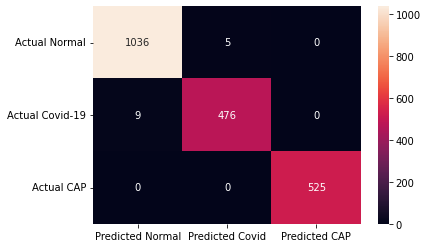

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, rounded_labels, labels=[0, 1, 2]),index=["Actual COVID-19", "Actual Normal", "Actual CAP"],
columns=["Predicted COVID-19", "Predicted Normal", "Predicted CAP"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")